In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve


%matplotlib inline

In [2]:
%%time
train_df = pd.read_csv("../../01_input/train.csv")
test_df = pd.read_csv("../../01_input/test.csv")
pred_df = pd.read_csv('../../04_predict_test/oka_252-2_LightGBM_submission.csv')
keras_pred_df = pd.read_csv('../../04_predict_test/242_keras_submission.csv')
keras_pred_df['keras_target']=keras_pred_df['target']

CPU times: user 11.3 s, sys: 408 ms, total: 11.8 s
Wall time: 11.8 s


In [3]:
train_df['new'] = (train_df['var_68']*10000).astype(int)
from datetime import datetime
train_df['var_68_asdate'] = datetime(1900, 1, 1).toordinal() +  train_df['new'] - 7000
train_df['var_68_asdate'] = train_df['var_68_asdate'].astype(int).apply(datetime.fromordinal)
train_df['release_year'] = train_df['var_68_asdate'].dt.year
train_df['release_month'] = train_df['var_68_asdate'].dt.month
train_df['release_quarter'] = train_df['var_68_asdate'].dt.quarter
train_df['release_dow'] = train_df['var_68_asdate'].dt.dayofweek
train_df['release_day'] = train_df['var_68_asdate'].dt.day
train_df = train_df.drop(['new','var_68_asdate'],axis=1)

In [4]:
submit_flg=1 #全件処理かどうかをコントロール
grid_flg=1 #GridSearchをするかコントロール
SEED=12345
sample_num=10000
fold_num=5

#train関連
train_drop_col=['ID_code','target']
train_label='target'

#test関連
test_drop_col=['ID_code']

In [5]:
#x,y作成
x_train=train_df.drop(train_drop_col,axis=1)
y_train=train_df[train_label]
x_train_base=train_df.drop(train_drop_col,axis=1)
y_train_base=train_df[train_label]
x_test=test_df.drop(test_drop_col,axis=1)
x_train_col=x_train.columns

In [6]:
import glob
train_stack_df=pd.DataFrame(y_train)
test_stack_df=pd.DataFrame()
files = glob.glob('../../03_predict_train/*')
i=0
for file in files:
    if 'US4' in file:
        i+=1
        print(file)
        train_stack_df_tmp=pd.read_csv(file)
        train_stack_df['pred_'+str(i)]=train_stack_df_tmp

files = glob.glob('../../04_predict_test/*')
i=0
for file in files:
    if 'US4' in file:
        i+=1
        print(file)
        test_stack_df_tmp=pd.read_csv(file)
        
        if i == 1 :
            test_stack_df=test_stack_df_tmp
            test_stack_df.columns=['pred_1']
        else:
            test_stack_df['pred_'+str(i)]=test_stack_df_tmp


../../03_predict_train/US4_train_6.csv
../../03_predict_train/US4_train_0.csv
../../03_predict_train/US4_train_10.csv
../../03_predict_train/US4_train_2.csv
../../03_predict_train/US4_train_9.csv
../../03_predict_train/US4_train_12.csv
../../03_predict_train/US4_train_3.csv
../../03_predict_train/US4_train_13.csv
../../03_predict_train/US4_train_5.csv
../../03_predict_train/US4_train_14.csv
../../03_predict_train/US4_train_4.csv
../../03_predict_train/US4_train_11.csv
../../03_predict_train/US4_train_7.csv
../../03_predict_train/US4_train_8.csv
../../03_predict_train/US4_train_1.csv
../../04_predict_test/US4_test_2.csv
../../04_predict_test/US4_test_5.csv
../../04_predict_test/US4_test_7.csv
../../04_predict_test/US4_test_3.csv
../../04_predict_test/US4_test_12.csv
../../04_predict_test/US4_test_14.csv
../../04_predict_test/US4_test_1.csv
../../04_predict_test/US4_test_10.csv
../../04_predict_test/US4_test_11.csv
../../04_predict_test/US4_test_8.csv
../../04_predict_test/US4_test_4.csv

In [7]:
y_train_stack_df=train_stack_df['target']
x_train_stack_df=train_stack_df.drop('target',axis=1)
x_train_stack_df['mean']=x_train_stack_df.mean(axis=1)
x_train_stack_df['max']=x_train_stack_df.max(axis=1)
x_train_stack_df['min']=x_train_stack_df.min(axis=1)
x_train_stack_df['std']=x_train_stack_df.std(axis=1)

x_test_stack_df=test_stack_df
x_test_stack_df['mean']=x_test_stack_df.mean(axis=1)
x_test_stack_df['max']=x_test_stack_df.max(axis=1)
x_test_stack_df['min']=x_test_stack_df.min(axis=1)
x_test_stack_df['std']=x_test_stack_df.std(axis=1)

In [8]:
pred_df['label']=pred_df['target']
df_check=pd.concat([x_train_stack_df['mean'],keras_pred_df['keras_target']],axis=1)
df_check=pd.concat([df_check,pred_df['label']],axis=1)
df_check['miss']=0
df_check=pd.concat([df_check,y_train_stack_df],axis=1)
df_check=pd.concat([df_check,x_train],axis=1)
df_check['miss'][(df_check['mean'] > 0.5) & (df_check['target']==0)]=1

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [9]:
df_check.head()

,mean,keras_target,label,miss,target,var_0,var_1,var_2,var_3,var_4,...,var_195,var_196,var_197,var_198,var_199,release_year,release_month,release_quarter,release_dow,release_day
0,0.036122,0.228561,0.125427,0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,...,-2.3978,7.8784,8.5635,12.7803,-1.0914,2018,1,1,3,11
1,0.696929,0.264062,0.183895,1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,...,2.0339,8.1267,8.7889,18.3560,1.9518,2018,5,2,2,2
2,0.023994,0.055033,0.184553,0,0,8.6093,-2.7457,12.0805,7.8928,10.5825,...,3.1417,-6.5213,8.2675,14.7222,0.3965,2018,5,2,3,10
3,0.491483,0.179801,0.164632,0,0,11.0604,-2.1518,8.9522,7.1957,12.5846,...,-1.2706,-2.9275,10.2922,17.9697,-8.9996,2018,5,2,2,2
4,0.258872,0.065044,0.057626,0,0,9.8369,-1.4834,12.8746,6.6375,12.2772,...,-1.5121,3.9267,9.5031,17.9974,-8.8104,2018,7,3,6,22


In [10]:
x_test_stack_df.head()

,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9,pred_10,pred_11,pred_12,pred_13,pred_14,pred_15,mean,max,min,std
0,0.351845,0.287049,0.338893,0.301523,0.314517,0.317818,0.326513,0.273614,0.315235,0.329322,0.308512,0.302337,0.272527,0.299520,0.349885,0.312607,0.351845,0.272527,0.025979
1,0.430416,0.438003,0.398194,0.420364,0.400058,0.380706,0.391792,0.462299,0.467725,0.468847,0.452122,0.466909,0.447137,0.438719,0.408615,0.431460,0.468847,0.380706,0.031193
2,0.422369,0.469076,0.401089,0.474984,0.439485,0.421118,0.440327,0.389649,0.439583,0.447883,0.470608,0.434656,0.435010,0.429370,0.418825,0.435602,0.474984,0.389649,0.026313
3,0.377699,0.403414,0.390639,0.396505,0.372701,0.404724,0.393548,0.431346,0.414353,0.438294,0.442795,0.340346,0.385191,0.426123,0.436163,0.403590,0.442795,0.340346,0.031608
4,0.120688,0.117561,0.120819,0.144650,0.145883,0.133725,0.115471,0.116814,0.143039,0.098506,0.113495,0.125937,0.117471,0.113983,0.130939,0.123932,0.145883,0.098506,0.014617


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


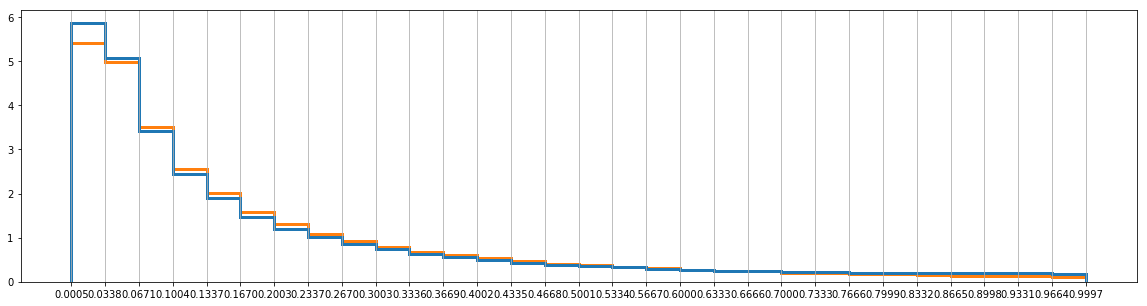

In [11]:
%matplotlib inline
from matplotlib import pyplot as plt

trainData = x_train_stack_df['mean']
testData = x_test_stack_df['mean']

fig, ax = plt.subplots(ncols = 1, figsize=(20,5))

outs1, outs2, outs3 = ax.hist([trainData, testData], 
                              bins=30, 
                              density = True, 
                              histtype='step', 
                              linewidth=3)
ax.set_xticks(outs2)
ax.xaxis.grid(True)

fig.show()
plt.show()

In [12]:
#0.5以上で間違えているものをカウント
print(len(df_check[(df_check['mean'] > 0.5) & (df_check['target']==0)]))
print(len(df_check[(df_check['mean'] > 0.5) & (df_check['target']==1)]))

11055
12498


In [13]:
#0.5未満で間違えているものをカウント
print(len(df_check[(df_check['mean'] < 0.5) & (df_check['target']==0)]))
print(len(df_check[(df_check['mean'] < 0.5) & (df_check['target']==1)]))

168847
7600


In [14]:
x_train_stack_df['mean'].to_csv('../../02_feature/122-2_train_mean.csv')
x_test_stack_df['mean'].to_csv('../../02_feature/122-2_test_mean.csv')

In [15]:
FN=df_check[(df_check['mean'] > 0.5) & (df_check['target']==0)]
TN=df_check[(df_check['mean'] > 0.5) & (df_check['target']==1)]

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt

trainData = x_train_stack_df['mean']
testData = x_test_stack_df['mean']

fig, ax = plt.subplots(ncols = 1, figsize=(20,5))

outs1, outs2, outs3 = ax.hist([trainData, testData], 
                              bins=30, 
                              density = True, 
                              histtype='step', 
                              linewidth=3)
ax.set_xticks(outs2)
ax.xaxis.grid(True)

fig.show()
plt.show()